<h1>Финальный проект по Временным рядам</h1>

<p style="font-style: italic;">Для работы я взял мультивариативный ряд погоды времен второй мировой войны. Решать буду задачу регрессии. Буду предсказывать погоду.</p>

<h3>Формулировка задания<h3>

##### Мультивариативный ряд

##### Задача: классификация или регрессия

##### Предобработка временного ряда
- Не менее 3 способов выделения свойств из временного ряда

##### Классические модели
- Не менее 2 классических моделей для прогнозирования временного ряда

##### Нейронные сети
- Не менее 3 нейронок для прогнозирования временного ряда

##### Метрики
- Не менее 5 метрик для каждой модели

##### Выводы
- Выводы по каждой модели и результатам в целом


<h4>Импорт библиотек</h4>

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from numpy import asarray
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data

random.seed(1488)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True

**Анализ данных и их предобработка**

In [2]:
file_path = '/content/Summary of Weather.csv'
data = pd.read_csv(file_path)
data = data.drop(['STA'], axis = 1)
data = data.drop(['Date'], axis = 1)
data = data.drop(['WindGustSpd'], axis = 1)
data = data.drop(['PoorWeather'], axis = 1)
data = data.drop(['YR'], axis = 1)
data = data.drop(['FB'], axis = 1)
data = data.drop(['FTI'], axis = 1)
data = data.drop(['ITH'], axis = 1)
data = data.drop(['PGT'], axis = 1)
data = data.drop(['TSHDSBRSGF'], axis = 1)
data = data.drop(['SD3'], axis = 1)
data = data.drop(['RHX'], axis = 1)
data = data.drop(['RHN'], axis = 1)
data = data.drop(['RVG'], axis = 1)
data = data.drop(['WTE'], axis = 1)
data = data.drop(['MO'], axis = 1)
data = data.drop(['DA'], axis = 1)
data = data.drop(['PRCP'], axis = 1)
data = data.drop(['DR'], axis = 1)
data = data.drop(['SPD'], axis = 1)
#data = data.drop(['MAX'], axis = 1)
#data = data.drop(['MIN'], axis = 1)
#data = data.drop(['MEA'], axis = 1)
data = data.drop(['SNF'], axis = 1)
data = data.drop(['SND'], axis = 1)
data = data.drop(['FT'], axis = 1)
data = data.drop(['Snowfall'], axis = 1)
data = data.drop(['MaxTemp'], axis = 1)
data = data.drop(['MinTemp'], axis = 1)
data = data.drop(['Precip'], axis = 1)
data = data.drop(['MeanTemp'], axis = 1)

<ipython-input-2-5c3f85a428aa>:2: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:
data

,MAX,MIN,MEA
0,78.0,72.0,75.0
1,84.0,71.0,78.0
2,79.0,72.0,76.0
3,80.0,72.0,76.0
4,80.0,71.0,76.0
...,...,...,...
119035,83.0,65.0,74.0
119036,85.0,65.0,75.0
119037,83.0,65.0,74.0
119038,83.0,65.0,74.0


In [ ]:
data.describe()

,MAX,MIN,MEA
count,118566.000000,118572.000000,118542.000000
mean,81.003745,64.273808,72.644843
std,14.869361,14.481498,14.211082
min,-28.000000,-37.000000,-32.000000
25%,78.000000,59.000000,69.000000
50%,85.000000,70.000000,78.000000
75%,89.000000,74.000000,81.000000
max,122.000000,94.000000,104.000000


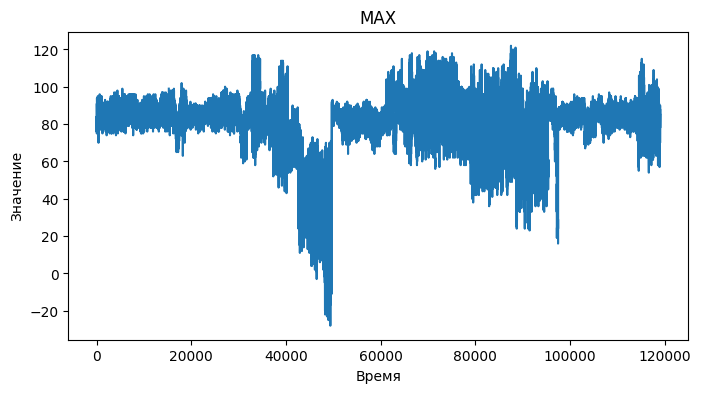

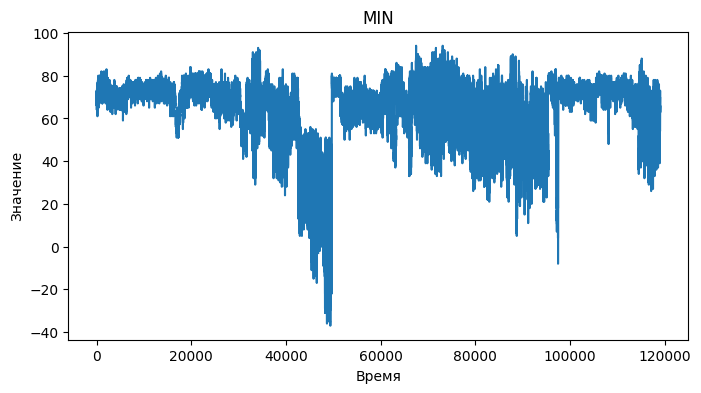

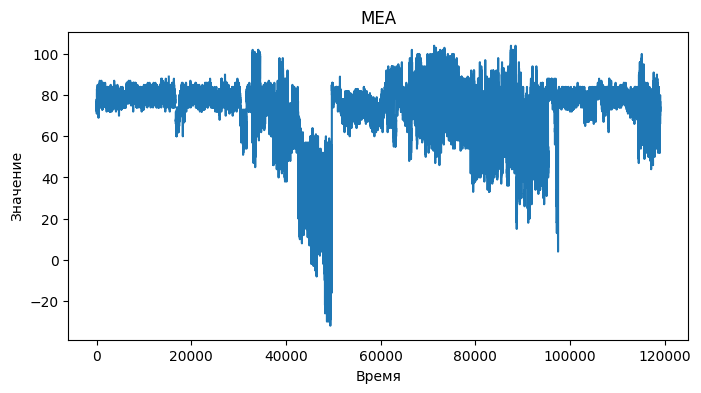

In [ ]:
columns = data.columns

for column in columns:
    if column != 'Date/Time':
        plt.figure(figsize=(8, 4))
        plt.plot(data[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()



In [7]:
missing_values = data.isnull().sum()
missing_values = pd.DataFrame(missing_values[missing_values>0])
missing_values

,0


In [6]:
for column in missing_values.index:
    data[column].fillna(method='ffill', inplace=True)
    data[column] = data[column].rolling(window=5, min_periods=1).mean()

*Было по одному пропущенному значению в каждом столбце. Устранил!*

Составляющие временного ряда:

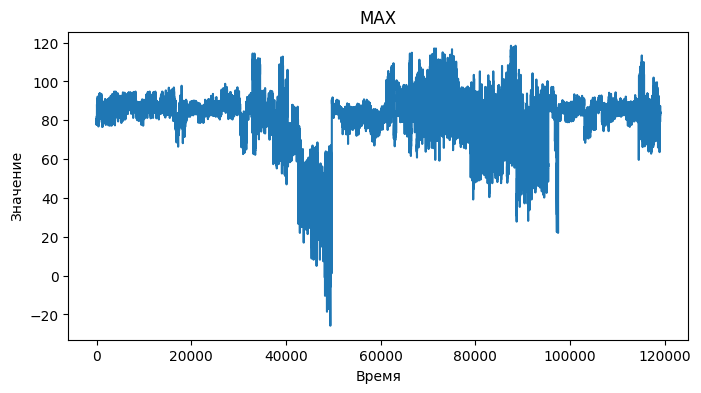

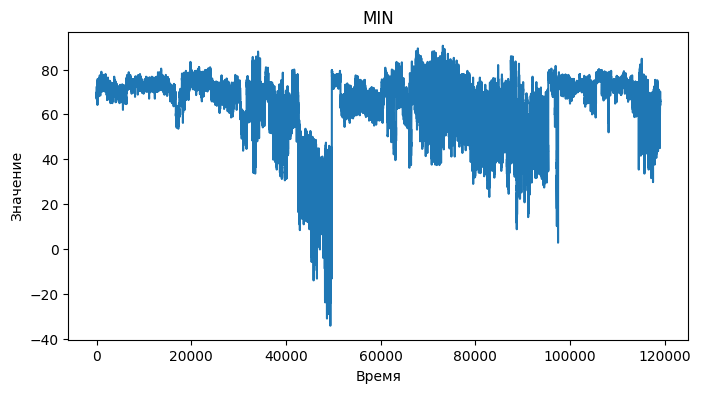

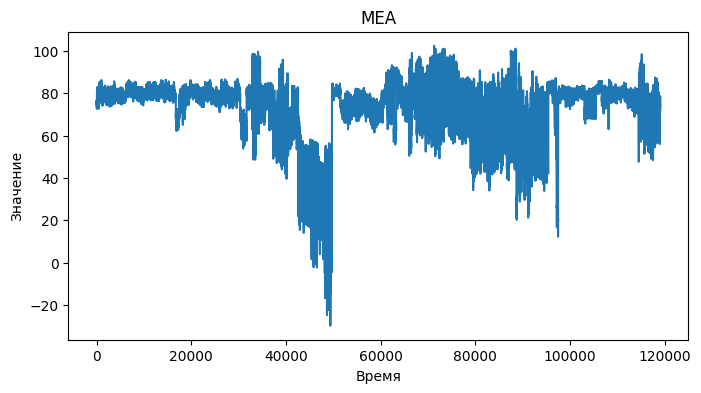

In [ ]:
columns = data.columns

for column in columns:
    if column != 'Date/Time':
        plt.figure(figsize=(8, 4))
        plt.plot(data[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()



In [ ]:
data.columns

Index(['MAX', 'MIN', 'MEA'], dtype='object')

Посмотрим на стационарность временных рядов.

In [ ]:
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [ ]:
for col in data.columns:
    if col != 'Date/Time':
        df_test(col, data[col])

Тест Дики-Фуллера ряда MAX:
Test Statistic                -1.714272e+01
p-value                        7.027306e-30
#Lags Users                    7.100000e+01
Number of Observations Used    1.189680e+05
Critical Value (1%)           -3.430405e+00
Critical Value (5%)           -2.861564e+00
Critical Value (10%)          -2.566783e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда MIN:
Test Statistic                -1.677615e+01
p-value                        1.275204e-29
#Lags Users                    7.100000e+01
Number of Observations Used    1.189680e+05
Critical Value (1%)           -3.430405e+00
Critical Value (5%)           -2.861564e+00
Critical Value (10%)          -2.566783e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда MEA:
Test Statistic                -1.728106e+01
p-value                        5.781594e-30
#Lags Users                    7.100000e+01
Number of Observations Used    1.189680e+05
Critical V

Для прогнозирования в моделях VAR, VARMA важна стационарность.
Для нейронок это уже необязательно.

**Коинтеграция**

Коинтеграция временных рядов – причинно-следственная зависимость в уровнях двух и более временных рядов, которая выражается в совпадении или противоположной направленности тенденций данных рядов и случайной колеблемости.

Если временные ряды коинтегрированы, это обычно означает, что можно строить модели, учитывающие их долгосрочные взаимосвязи для лучших предсказаний (VAR, VARMA и т.д.).


In [ ]:
from itertools import combinations
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR


In [ ]:
pairs = combinations(data.columns, 2)

for pair in pairs:
    pair_data = data[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между MAX и MIN
Есть коинтеграция между MAX и MEA
Есть коинтеграция между MIN и MEA


**Причинность рядов по Грейнджеру**

In [ ]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(data, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 3/3 [00:37<00:00, 12.35s/it]


,MAX_x,MIN_x,MEA_x
MAX_y,1.0,0.0,0.0
MIN_y,0.0,1.0,0.0
MEA_y,0.0,0.0,1.0


Если результат теста Грейнджера показывает строгое значение p-уровня значимости равное нулю или близкое к нулю (< 0.05)(у нас как раз нуль) для пары временных рядов, это обычно интерпретируется как сильное статистическое доказательство в пользу наличия причинной связи между этими рядами. Ну и как итог - VAR модели подходят идеально.

**Прогнозирование временного ряда**


VAR

VAR (Vector AutoRegression) - это тип статистической модели временных рядов, используемой для прогнозирования изменений в нескольких взаимосвязанных переменных с течением времени. Это многомерное расширение модели авторегрессии (AR).

VAR моделирует каждую переменную как линейную комбинацию ее предыдущих значений и предыдущих значений других переменных. Таким образом, все переменные в системе рассматриваются как эндогенные, и модель позволяет нам улучшить прогнозы путем учета взаимосвязей между переменными.

Для начала - подберем наилучший порядок, исходя из информационных критериев:

AIC (Akaike Information Criterion)
BIC (Bayesian Information Criterion)
FPE (Final Prediction Error)
HQC (Hannan-Quinn Criterion).

Меньшие значения критериев указывают на лучшую модель, и их можно использовать для выбора оптимального порядка модели VAR.


In [ ]:
train = data[:int(len(data)*0.70)]
test = data[int(len(data)*0.70):len(data)]


model = VAR(train)

orders = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 20, 21, 23, 30, 35, 150,366]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]

for i,j in enumerate(zip(*results)):
    print('Lag Order =', orders[i])
    print('AIC : ', j[0], "*" if i == best_pos[0] else "")
    print('BIC : ', j[1], "*" if i == best_pos[1] else "")
    print('FPE : ', j[2], "*" if i == best_pos[2] else "")
    print('HQIC: ', j[3], "*" if i == best_pos[3] else "", '\n')

Lag Order = 1
AIC :  -4.22918099005946 
BIC :  -4.227837291920039 
FPE :  0.014564313982976342 
HQIC:  -4.2287698386197  

Lag Order = 2
AIC :  -4.947462445530087 
BIC :  -4.945110948590472 
FPE :  0.007101406290035212 
HQIC:  -4.946742922409437  

Lag Order = 3
AIC :  -4.969919354388449 
BIC :  -4.966560037051572 
FPE :  0.0069437079917682035 
HQIC:  -4.968891452642867  

Lag Order = 4
AIC :  -4.9823732713782345 
BIC :  -4.978006112046299 
FPE :  0.006857767885116488 
HQIC:  -4.981036984063438  

Lag Order = 5
AIC :  -5.047703609509016 
BIC :  -5.042328586583492 
FPE :  0.0064240686911895386 
HQIC:  -5.04605892968048  

Lag Order = 6
AIC :  -5.564076923337905 
BIC :  -5.557694015219535 
FPE :  0.0038331171738010517 
HQIC:  -5.562123844050865  

Lag Order = 7
AIC :  -5.722272192345258 
BIC :  -5.714881377434051 
FPE :  0.0032722672283892564 
HQIC:  -5.7200107066547075  

Lag Order = 8
AIC :  -5.729839735783429 
BIC :  -5.721440992478663 
FPE :  0.0032475976657772307 
HQIC:  -5.72726983

Обучаем модель с наилучшим порядком (336)

In [ ]:
model_fitted = model.fit(336)
model_fitted.summary()



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 13, Jan, 2024
Time:                     09:10:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.34560
Nobs:                     82992.0    HQIC:                  -6.58166
Log likelihood:          -72822.1    FPE:                 0.00124856
AIC:                     -6.68577    Det(Omega_mle):      0.00120411
--------------------------------------------------------------------
Results for equation MAX
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.039188         0.014899            2.630           0.009
L1.MAX           1.621313         0.013565          119.522           0.000
L1.MIN           0.086238         0.013743            6.275           0.000
L1.MEA

Теперь подготовим тестовые данные для предсказания, и сделаем их

In [ ]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train



In [ ]:
X_test, Y_test = create_test_dataset(test, 336)
X_train, Y_train = create_train_dataset(train, 336)

In [ ]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))



In [ ]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)



Посчитаем метрики и отрисуем графики.

In [ ]:


def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)



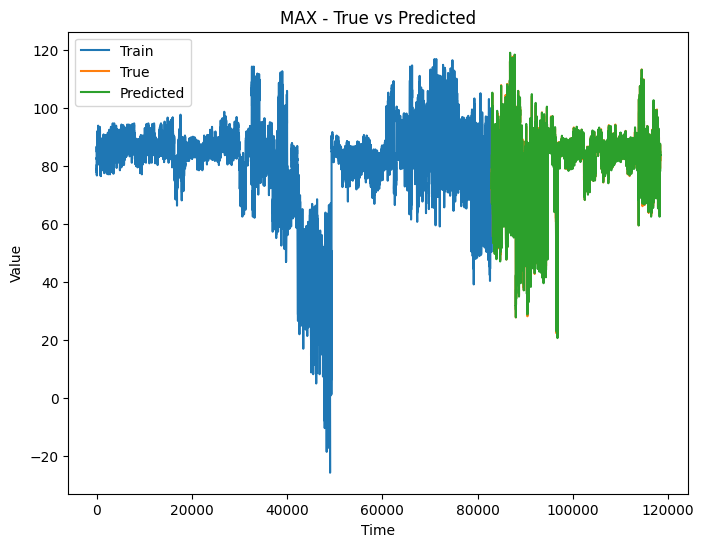

Метрики MAX
MSE: 0.4935299016955817
RMSE: 0.7025168337453429
MAE: 0.48643969176737956
SMAPE: 0.002
R2: 0.996835050084783 



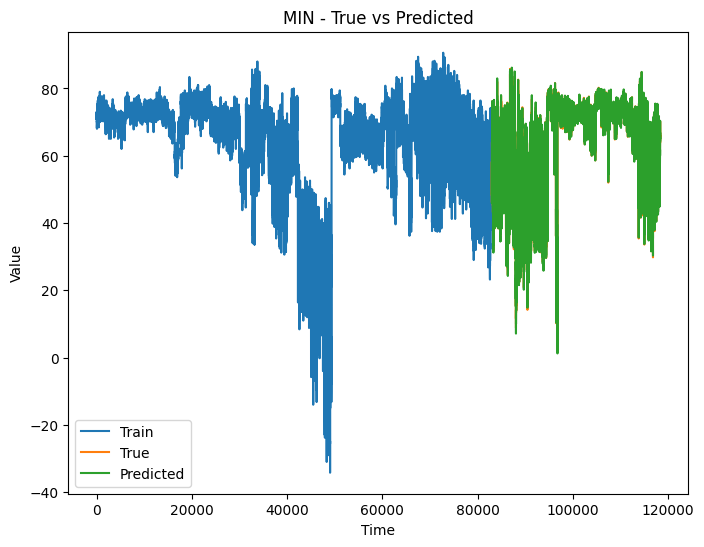

Метрики MIN
MSE: 0.3795870732410972
RMSE: 0.6161063814318898
MAE: 0.43182401618245736
SMAPE: 0.002
R2: 0.9977545801918521 



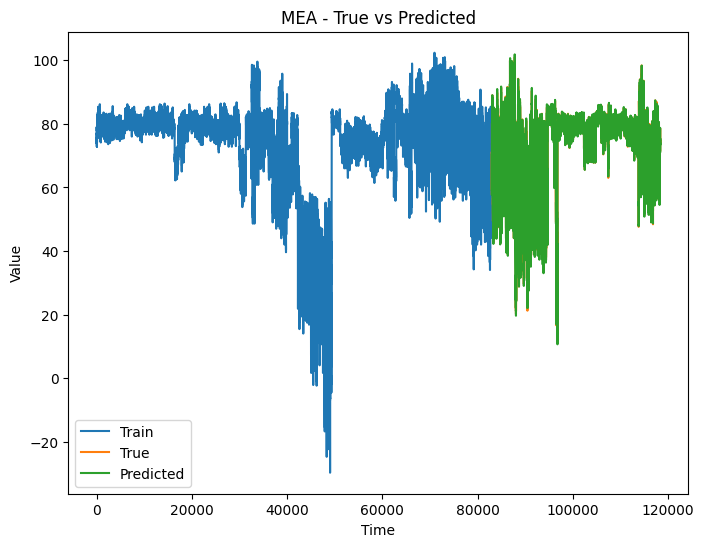

Метрики MEA
MSE: 0.28632107131044293
RMSE: 0.5350897787385244
MAE: 0.37366250949814683
SMAPE: 0.001
R2: 0.9980973503328454 



In [ ]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)

По результатам метрик:

    Среднеквадратичная ошибка (MSE), корень из среднеквадратичной ошибки (RMSE) и средняя абсолютная ошибка (MAE) находятся на уровне ниже единицы, что свидетельствует о хорошем качестве модели и близости прогнозов к фактическим значениям.
    Симметричное среднее абсолютное процентное отклонение (SMAPE) также демонстрирует хорошие результаты, приближаясь к нулю, что является показателем высокой точности модели.
    Коэффициент детерминации (R2) близок к 0.99, что говорит о высокой степени соответствия между прогнозируемыми и реальными значениями. Этот результат можно оценить как практически идеальный, поскольку он очень близок к единице.

Таким образом, все метрики указывают на высокое качество модели и ее способность точно предсказывать целевую переменную.

**VARMA**



VARMA (Vector AutoRegressive Moving-Average) - это стохастическая модель, используемая в области временных рядов для моделирования взаимосвязей между несколькими временными рядами одновременно. В этой модели предполагается, что каждый из временных рядов влияет на другие.

VARMA - это обобщение модели ARMA (AutoRegressive Moving Average). В модели ARMA каждый временной ряд моделируется на основе его собственных предыдущих значений (авторегрессионный элемент) и ошибок прогнозирования (скользящая средняя).

Однако в модели VARMA каждый временной ряд моделируется не только на основе его собственных предыдущих значений, но и на основе предыдущих значений других временных рядов.


In [ ]:
X = data
data = data[:int(len(data)*0.3)]
train, test = X[:25000], X[25000:30000]


In [ ]:
train

,MAX,MIN,MEA
0,78.000000,72.000000,75.000000
1,81.000000,71.500000,76.500000
2,80.333333,71.666667,76.333333
3,80.250000,71.750000,76.250000
4,80.200000,71.600000,76.200000
...,...,...,...
24995,84.400000,71.200000,77.600000
24996,84.400000,71.400000,77.800000
24997,84.800000,71.800000,78.200000
24998,84.800000,71.800000,78.200000


In [ ]:
data

,MAX,MIN,MEA
0,78.000000,72.000000,75.000000
1,81.000000,71.500000,76.500000
2,80.333333,71.666667,76.333333
3,80.250000,71.750000,76.250000
4,80.200000,71.600000,76.200000
...,...,...,...
35707,82.600000,74.800000,78.800000
35708,82.800000,75.200000,79.200000
35709,83.000000,76.000000,79.600000
35710,83.000000,76.400000,79.600000


In [ ]:
from pmdarima.arima import auto_arima
import pandas as pd
pq = []
for name, column in data.items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))



Searching order of p and q for : MAX
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71518.152, Time=10.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77962.609, Time=4.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71516.576, Time=4.88 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=72538.183, Time=7.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77960.610, Time=0.69 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71518.077, Time=6.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=70983.476, Time=38.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=70769.012, Time=39.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=71477.354, Time=7.80 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=68976.307, Time=35.59 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=70745.614, Time=10.70 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=62998.346, Time=34.32 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=64364.484, Time=14.51 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=

In [ ]:
pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:85: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/pmdarima-2.0.4.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:


pq



[(7, 1, 1), (7, 1, 1), (7, 1, 1)]

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
import pandas as pd
from sklearn import metrics
import numpy as np
df_results_moni = pd.DataFrame(columns=['p', 'q','MAX','MIN','MEA'])
df_results_moni = df_results_moni.apply(pd.to_numeric, errors='coerce')


for i in pq[1:len(pq)]:
    if i[0]== 0 and i[2]==0:
        pass
    else:
        model = VARMAX(train, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(test))
        MAX_rmse = np.sqrt(metrics.mean_squared_error(test['MAX'], result['MAX']))
        MIN_rmse = np.sqrt(metrics.mean_squared_error(test['MIN'], result['MIN']))
        MEA_rmse = np.sqrt(metrics.mean_squared_error(test['MEA'], result['MEA']))
        new_row = {'p': i[0], 'q': i[2], 'RMSE MAX': MAX_rmse,'RMSE MIN': MIN_rmse,'RMSE MEA': MEA_rmse }
        df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
df_results_moni.sort_values(by = ['MAX','MIN','MEA'] )

,p,q,MAX,MIN,MEA,RMSE MAX,RMSE MIN,RMSE MEA
0,7,1,NaN,NaN,NaN,3.653505,3.994275,2.492521
1,7,1,NaN,NaN,NaN,3.653505,3.994275,2.492521


In [ ]:
model = VARMAX(train, order=(7,1)).fit(disp=False)
result = model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:


result



,MAX,MIN,MEA
25000,83.633109,72.096368,77.678384
25001,83.557587,72.085665,77.596645
25002,83.360372,71.924421,77.424220
25003,83.383325,71.946875,77.451623
25004,83.901290,71.751201,77.667737
...,...,...,...
29995,86.268468,72.590982,79.449739
29996,86.268468,72.590982,79.449739
29997,86.268468,72.590982,79.449739
29998,86.268468,72.590982,79.449739


In [ ]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'SMAPE: {smape_score(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

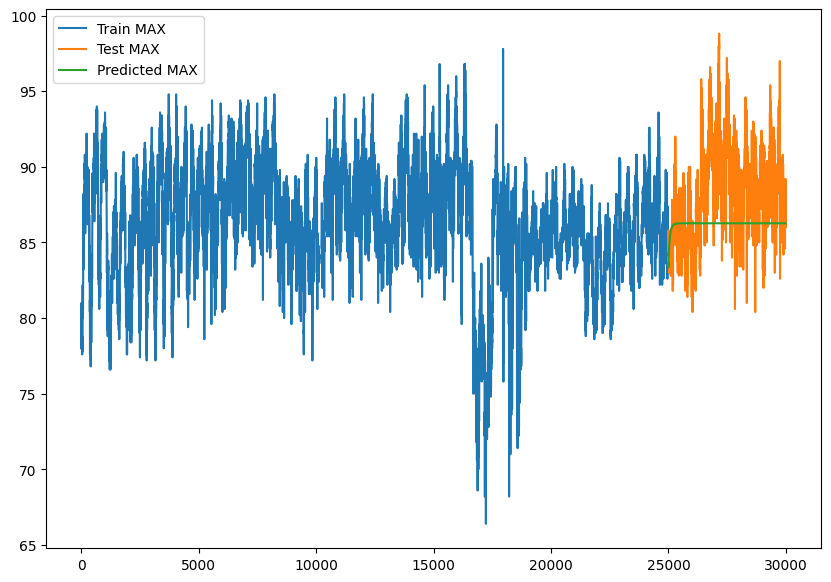

Evaluation metric for MAX
MSE: 13.348100638840847
MAE: 2.9006369677810593
RMSE: 3.6535052537037425
SMAPE: 0.008
R2: -0.4982366109433587



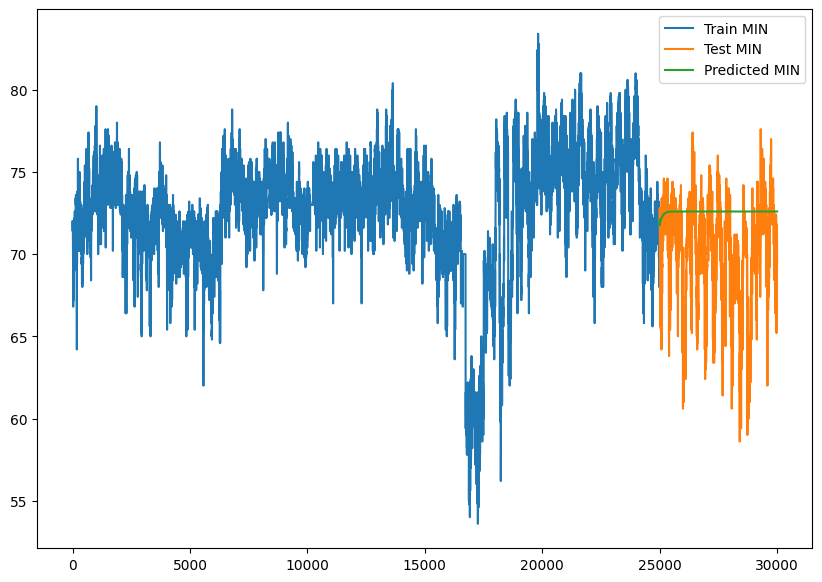

Evaluation metric for MIN
MSE: 15.954235881271067
MAE: 2.9511571110031123
RMSE: 3.9942753887621554
SMAPE: 0.011
R2: -0.6542546539256151



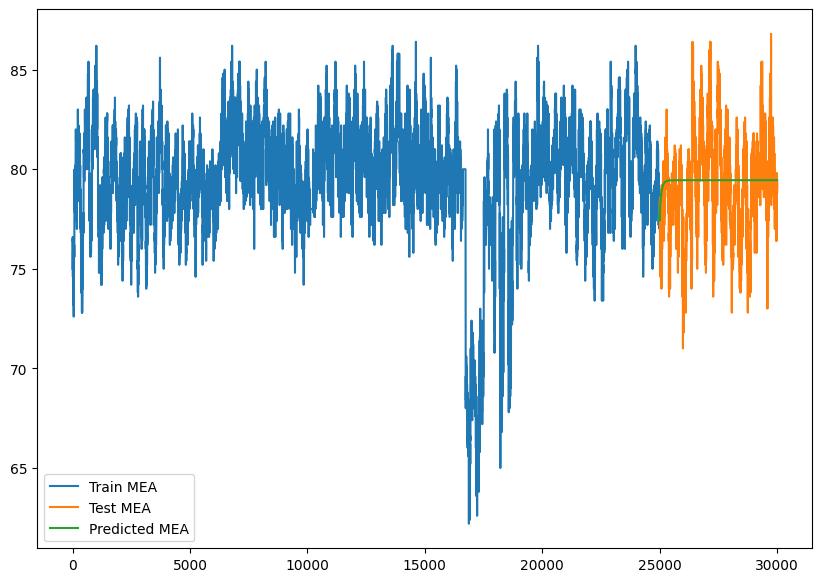

Evaluation metric for MEA
MSE: 6.212660914896313
MAE: 1.9605144671861263
RMSE: 2.4925209958787335
SMAPE: 0.006
R2: 0.006801305837921379



In [ ]:
for i in ['MAX','MIN','MEA']:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(train[str(i)], label='Train '+str(i))
    plt.plot(range(25000, 30000), test[str(i)], label='Test '+str(i))
    plt.plot(range(25000, 30000), result[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , result[str(i)])



На всех метриках MSE, RMSE - удовлетворельны, MAE показал неплохой результат, SMAPE не так идеален, но тоже более менее удовлетворителен, R2 - отрицателен(кроме последней), поэтому это плохо.

Первая метрика дала удовлетворительный MSE, RMSE, хороший MAE, хороший SMAPE, но опять же отрицательный R2, что опять же плохо.

Со второй метрикой всё немного хуже: MSE, RMSE оставляют желать лучше R2 - отрицателен, но уже его значение ниже, чем для других рядов, что ещё хуже.

Как итог - метрики удовлетворительны, но на самом деле они оставляют желать лучшего.


**Нейросети**


LSTM

LSTM (Long Short-Term Memory) - это тип рекуррентной нейронной сети (RNN), разработанный для работы с последовательными данными, такими как временные ряды, тексты, аудио и другие последовательные данные.

Основная особенность LSTM заключается в способности учитывать зависимости и долгосрочные зависимости в данных, что часто бывает сложно для обычных RNN. Они обладают способностью запоминать информацию на протяжении длительных временных интервалов и избегать проблемы затухания/взрыва градиентов, которая часто встречается у обычных RNN.

Определим саму модель нейросети.


In [10]:
df_LSTM = pd.DataFrame(data)
df_LSTM['MAX'] = data['MAX']
df_LSTM['MIN'] = data['MIN']
df_LSTM['MEA'] = data['MEA']


lookback_window = 1

df_LSTM = df_LSTM.values
scaler = MinMaxScaler()

x, y = [], []
for i in range(lookback_window, len(df_LSTM)):
    x.append(df_LSTM[i - lookback_window:i])
    y.append(df_LSTM[i])
x = np.array(x)
y = np.array(y)

In [9]:
from sklearn.preprocessing import MinMaxScaler


Определим функцию разделения датасета

In [11]:
def data_split(ts, param="2", train_percentage=0.7):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

И создания для подачи на вход LSTM.

In [12]:
x_train = x[0:25000]
y_train = y[0:25000]
x_test = x[25000:30000]
y_test = y[25000:30000]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 3)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3)).reshape(x_test.shape)

Создади функцию для обучения модели и предсказаний.

In [21]:
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Model

i = Input(shape=(lookback_window, 3))
m = LSTM(units=90, activation='tanh', return_sequences=False)(i)
m = Dense(3, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 90)                33840     
                                                                 
 dense_3 (Dense)             (None, 3)                 273       
                                                                 
Total params: 34113 (133.25 KB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

In [23]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 3)).reshape(y_pred_scaled.shape)

157/157 [==============================] - 3s 3ms/step


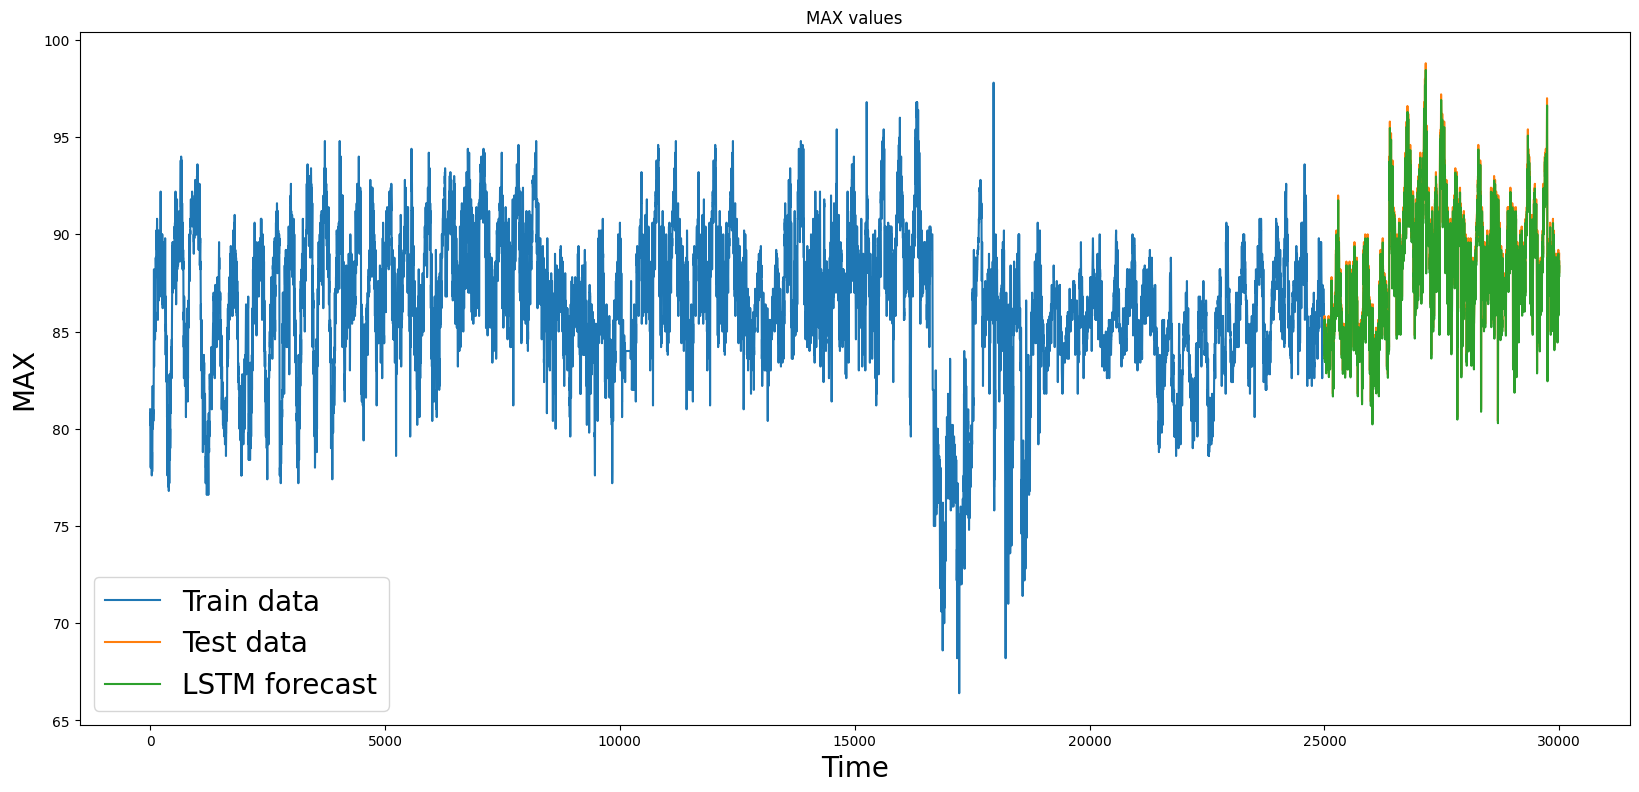

LSTM Metrics MAX:
RMSE: 0.6864064670791121
MSE: 0.47115383804802824
SMAPE: 0.001
MAE: 0.5080125411987305
R^2: 0.9470914649286559


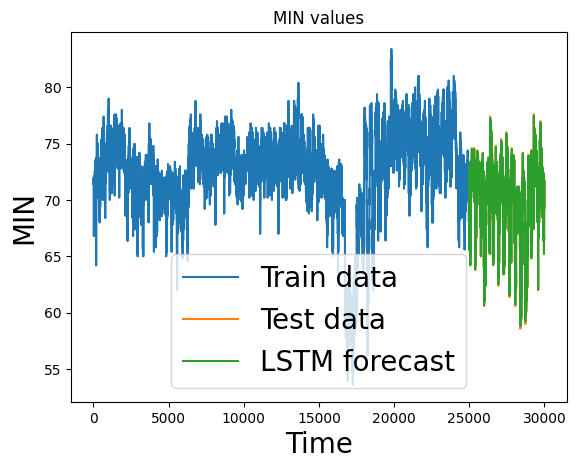

LSTM Metrics MIN:
RMSE: 0.583717498089176
MSE: 0.34072611757548715
SMAPE: 0.002
MAE: 0.44431894256591786
R^2: 0.9646687639774528


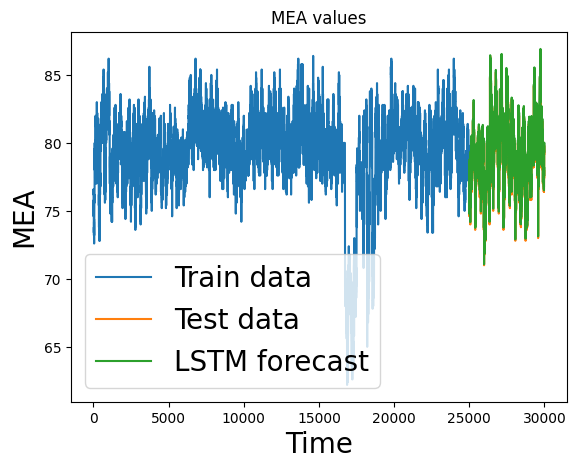

LSTM Metrics MEA:
RMSE: 0.48431389854063606
MSE: 0.23455995231962953
SMAPE: 0.001
MAE: 0.37707411804199215
R^2: 0.9624984557981993


In [24]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ["MAX", "MIN", "MEA"]

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='LSTM forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"LSTM Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

Все метрики показывают примерно одинаково высокое качество модели, что делает их просто отличными.
Значения корня из среднеквадратичной ошибки (RMSE), среднеквадратичной ошибки (MSE) и средней абсолютной ошибки (MAE) меньше единицы и даже меньше 0.5, что хорошо.
Значение симметричного среднего абсолютного процентного отклонения (SMAPE) также меньше единицы и даже очень близко к нулю, что также можно оценить как практически идеальное.
Коэффициент детерминации (R2) можно назвать практически идеальным с небольшими погрешностями.
Таким образом, все метрики указывают на высокое качество модели, подтверждая ее способность делать точные прогнозы.

**GRU**



GRU (Gated Recurrent Units) - это один из типов рекуррентных нейронных сетей, предложенный в 2014 году. Он был создан как более простая альтернатива LSTM (Long Short-Term Memory), другому типу рекуррентных сетей.

Главной отличительной особенностью GRU является меньшее число элементов управления или "ворот". У LSTM есть три ворота: входное, забывающее и выходное, а у GRU - всего два: обновляющее и сбрасывающее.

Обновляющее ворото в модели GRU определяет, какую часть предыдущего состояния следует сохранить, а сбрасывающее ворото контролирует, как много прошлого состояния использовать для вычисления текущего состояния.

По сути, GRU пытается решить проблему памяти в обычных рекуррентных сетях, взяв наиболее эффективные элементы LSTM, но упростив их. И, хотя GRU модели обычно требуют меньше объема вычислений по сравнению с LSTM, их эффективность сильно зависит от конкретной задачи.

Определим данные и масштабируем их.


In [25]:
df_GRU = pd.DataFrame(data)
df_GRU['MAX'] = data['MAX']
df_GRU['MIN'] = data['MIN']
df_GRU['MEA'] = data['MEA']

lookback_window = 1

df_GRU = df_GRU.values
scaler = MinMaxScaler()

x, y = [], []
for i in range(lookback_window, len(df_LSTM)):
    x.append(df_GRU[i - lookback_window:i])
    y.append(df_GRU[i])
x = np.array(x)
y = np.array(y)

In [26]:


x_train = x[0:25000]
y_train = y[0:25000]
x_test = x[25000:30000]
y_test = y[25000:30000]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 3)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3)).reshape(x_test.shape)



In [28]:
from keras.layers import GRU

i = Input(shape=(lookback_window, 3))
m = GRU(units=90, activation='tanh', return_sequences=False)(i)
m = Dense(3, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 gru (GRU)                   (None, 90)                25650     
                                                                 
 dense_4 (Dense)             (None, 3)                 273       
                                                                 
Total params: 25923 (101.26 KB)
Trainable params: 25923 (101.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

In [30]:


y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 3)).reshape(y_pred_scaled.shape)



157/157 [==============================] - 1s 2ms/step


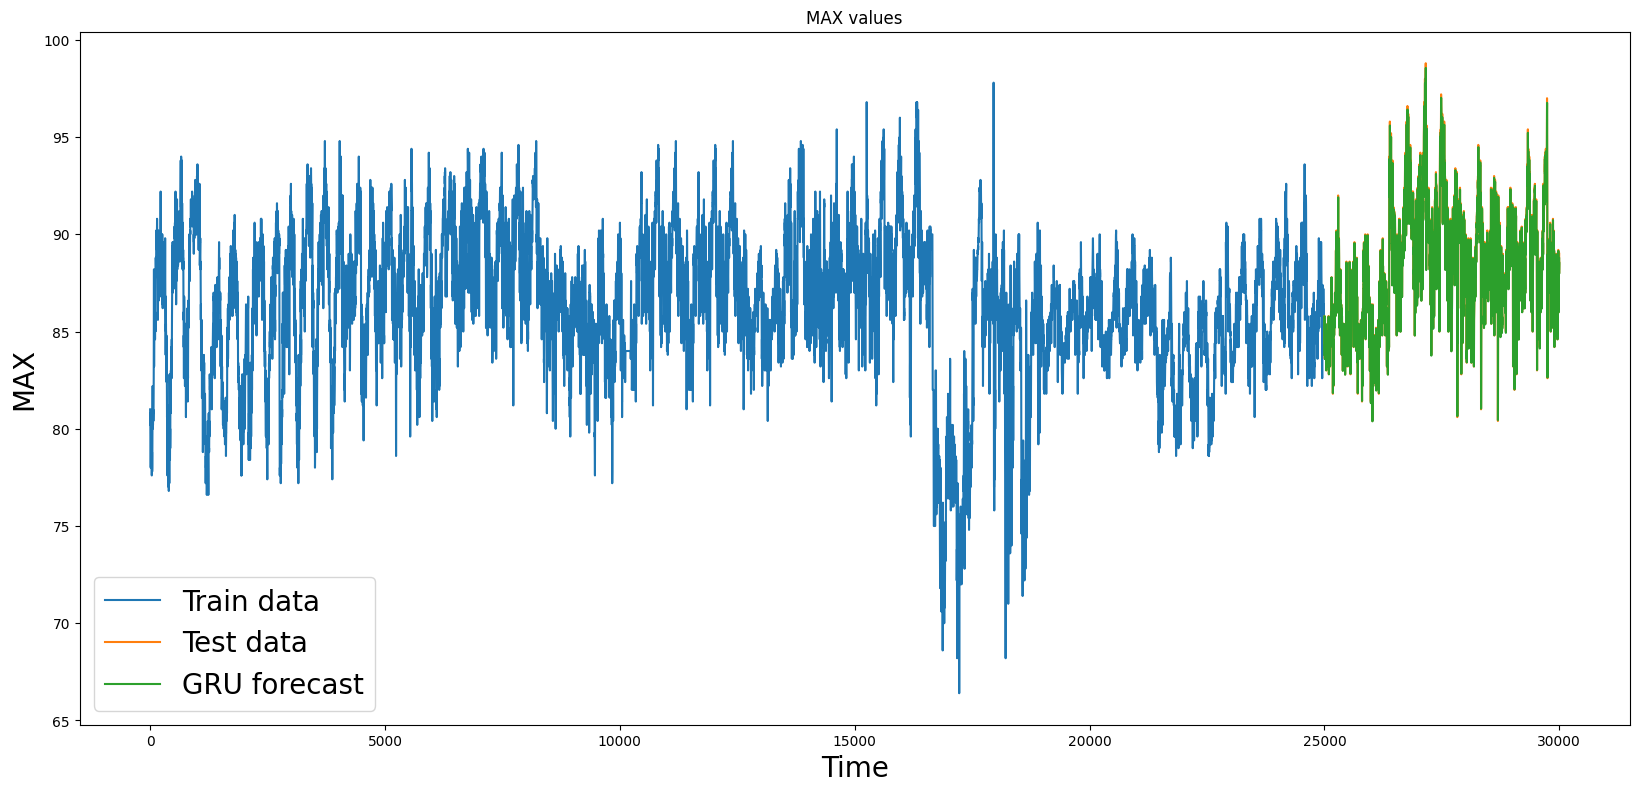

GRU Metrics MAX:
RMSE: 0.6574633678128263
MSE: 0.4322580800157837
SMAPE: 0.001
MAE: 0.47837379852294926
R^2: 0.951459290067259


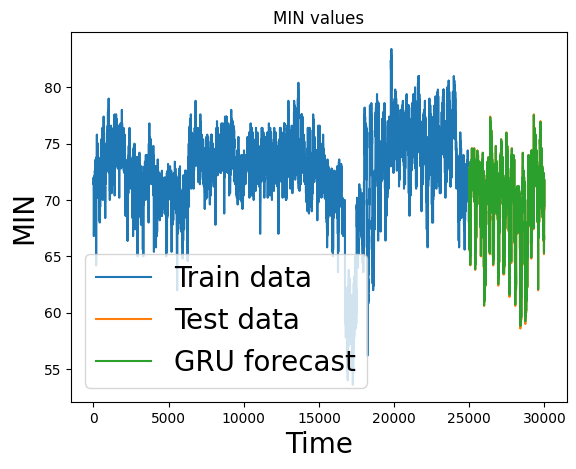

GRU Metrics MIN:
RMSE: 0.5857038449397688
MSE: 0.3430489939772287
SMAPE: 0.002
MAE: 0.4466330136108398
R^2: 0.9644278957546553


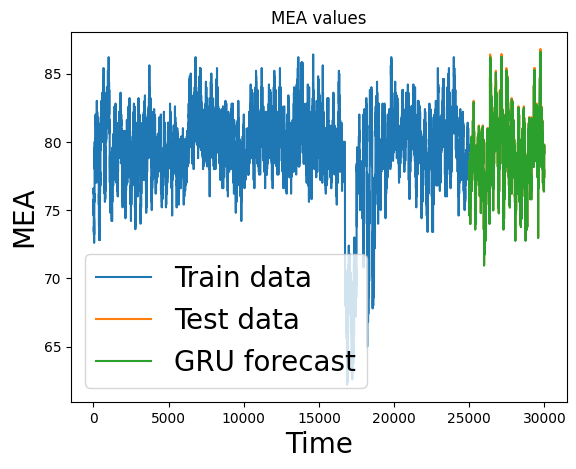

GRU Metrics MEA:
RMSE: 0.4553050846458526
MSE: 0.207302720104367
SMAPE: 0.001
MAE: 0.34466393524169914
R^2: 0.9668563535920499


In [31]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ['MAX', 'MIN', 'MEA']

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='GRU forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"GRU Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

В целом показала такой же результат, как и LSTM. Только немного лучше)

**TCN**



TCN (Temporal Convolutional Network) - это тип нейронной сети, предназначенный для работы с последовательными данных, такими как временные ряды. Эта архитектура основана на использовании сверточных слоев для извлечения признаков из последовательных данных.

Подготовим данные.


In [33]:
df_tcn = pd.DataFrame(data)
df_tcn['MAX'] = data['MAX']
df_tcn['MIN'] = data['MIN']
df_tcn['MEA'] = data['MEA']

lookback_window = 20

df_tcn = df_tcn.values

x, y = [], []
for i in range(lookback_window, len(df_tcn)):
    x.append(df_tcn[i - lookback_window:i])
    y.append(df_tcn[i])
x = np.array(x)
y = np.array(y)

In [34]:


x_train = x[0:25000]
y_train = y[0:25000]
x_test = x[25000:30000]
y_test = y[25000:30000]



In [38]:
from tcn import TCN


i = Input(shape=(lookback_window, 3))
m = TCN()(i)
m = Dense(3, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20, 3)]           0         
                                                                 
 tcn (TCN)                   (None, 64)                136768    
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 136963 (535.01 KB)
Trainable params: 136963 (535.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
pip install keras-tcn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.6 MB/s eta 0:00:00


In [39]:


model.fit(x_train, y_train, epochs=100, verbose=0)



In [40]:
y_pred = model.predict(x_test)

157/157 [==============================] - 3s 15ms/step


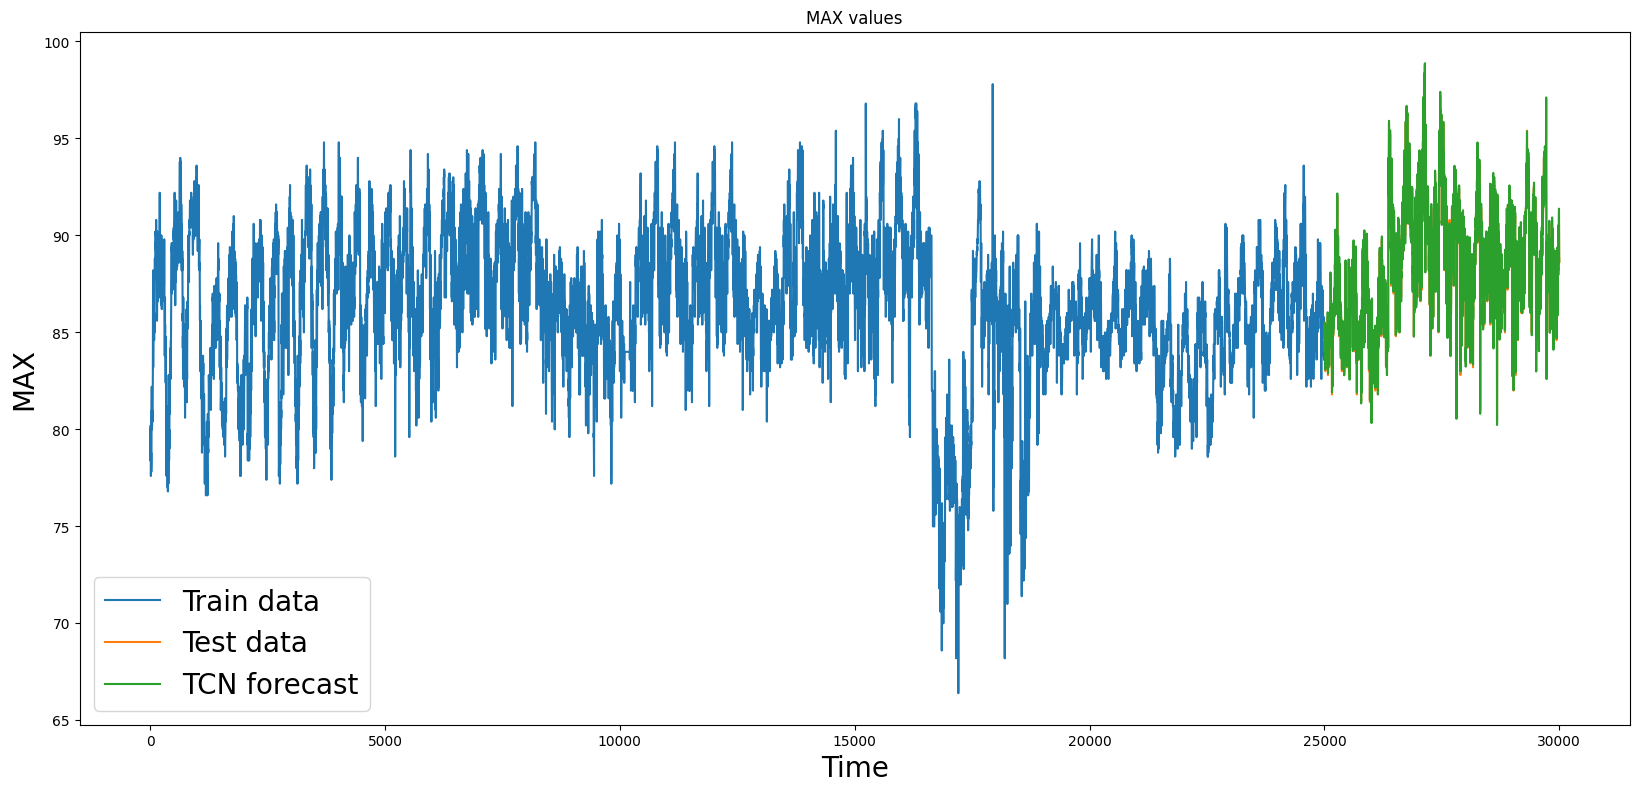

TCN Metrics MAX:
RMSE: 0.6218152581459416
MSE: 0.38665421526310406
SMAPE: 0.001
MAE: 0.45175731994628904
R^2: 0.9563150549253128


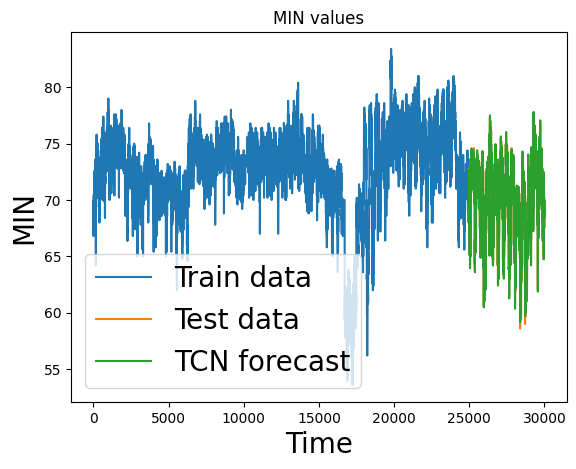

TCN Metrics MIN:
RMSE: 0.5361349491048922
MSE: 0.28744068365170544
SMAPE: 0.001
MAE: 0.4126616987609863
R^2: 0.970161685913494


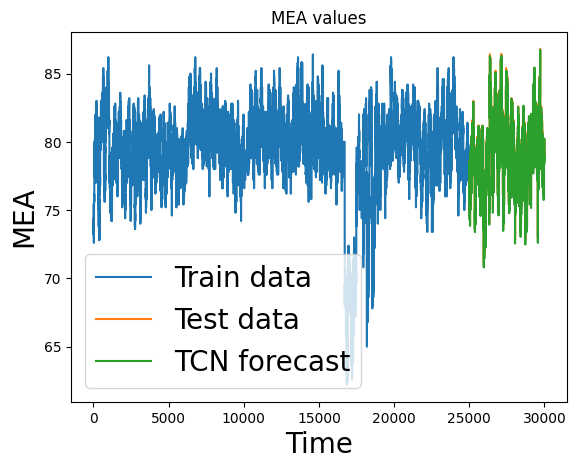

TCN Metrics MEA:
RMSE: 0.4452111037898522
MSE: 0.19821292693777853
SMAPE: 0.001
MAE: 0.34484809265136723
R^2: 0.9681708889257081


In [41]:


fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ['MAX', 'MIN', 'MEA']

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='TCN forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"TCN Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))



Впринципе результат такой же как на других. Лучший результат на GRU. Только вот еще TCN 40 мин обучалась)

***Итог:***

Из моего исследования следует, что среди классических моделей наилучшие результаты продемонстрировала VAR. Эта модель быстро подбирала оптимальные параметры для обучения и обучалась с высокой скоростью, обеспечивая качественные прогнозы. Что касается VARMAX, плохие результаты могли быть обусловлены неправильным подбором параметров. Я предположил, что параметры из VAR можно было бы интерпретировать на VARMA, но обучение заняло бы слишком много времени, и результаты могли бы быть неудовлетворительными.

При анализе нейронных сетей, я отметил, что модель GRU предпочтительнее благодаря своей простоте настройки и обучения. Также я обратил внимание на то, что модель TCN показала отличные результаты на неотмасштабированных данных, что свидетельствует о ее высокой эффективности.

В итоге, мои исследования показали, что нейронные сети превзошли классические алгоритмы прогнозирования благодаря их способности работать с данными без необходимости предварительной подготовки, дифференциации рядов для достижения стационарности и обеспечения отличного качества прогнозов без искажения предсказанных данных. Это подчеркивает важность выбора подходящей модели в зависимости от особенностей данных и требуемого качества прогнозов.